In [1]:
import sys
import os
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import torch
from PIL import Image



# 1. Load Pretrained Model BLIP 

In [2]:
!pip install --no-index --no-deps /kaggle/input/lavis-pretrained/salesforce-lavis/transformers* 
!pip install --no-index --no-deps /kaggle/input/lavis-pretrained/salesforce-lavis/hugging*

Processing /kaggle/input/lavis-pretrained/salesforce-lavis/transformers-4.26.1-py3-none-any.whl
  Attempting uninstall: transformers
    Found existing installation: transformers 4.28.1
    Uninstalling transformers-4.28.1:
      Successfully uninstalled transformers-4.28.1
Processing /kaggle/input/lavis-pretrained/salesforce-lavis/huggingface_hub-0.12.0-py3-none-any.whl
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.13.4
    Uninstalling huggingface-hub-0.13.4:
      Successfully uninstalled huggingface-hub-0.13.4


In [3]:
from transformers import AutoProcessor, BlipForConditionalGeneration

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
processor = AutoProcessor.from_pretrained("/kaggle/input/blip-pretrained-model/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("/kaggle/input/blip-pretrained-model/blip-image-captioning-large")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

# 1.1 Apply an example 

In [6]:
comp_path = Path('/kaggle/input/stable-diffusion-image-to-prompts/')
sample_submission = pd.read_csv(comp_path / 'sample_submission.csv', index_col='imgId_eId')

In [7]:
def load_image_paths(image_dir, image_ids):
    image_path_list = []
    image_set = set()
    for image_id in image_ids:
        if image_id in image_set:
            continue
        image_set.add(image_id)
        image_path_list.append(f"{image_dir}/{image_id}.png")
    return image_path_list

In [8]:
image_ids = [val.split("_")[0] for val in sample_submission.index]
image_dir = "/kaggle/input/stable-diffusion-image-to-prompts/images"
image_path_list = load_image_paths(image_dir, image_ids)
image_path_list

['/kaggle/input/stable-diffusion-image-to-prompts/images/20057f34d.png',
 '/kaggle/input/stable-diffusion-image-to-prompts/images/227ef0887.png',
 '/kaggle/input/stable-diffusion-image-to-prompts/images/92e911621.png',
 '/kaggle/input/stable-diffusion-image-to-prompts/images/a4e1c55a9.png',
 '/kaggle/input/stable-diffusion-image-to-prompts/images/c98f79f71.png',
 '/kaggle/input/stable-diffusion-image-to-prompts/images/d8edf2e40.png',
 '/kaggle/input/stable-diffusion-image-to-prompts/images/f27825b2c.png']

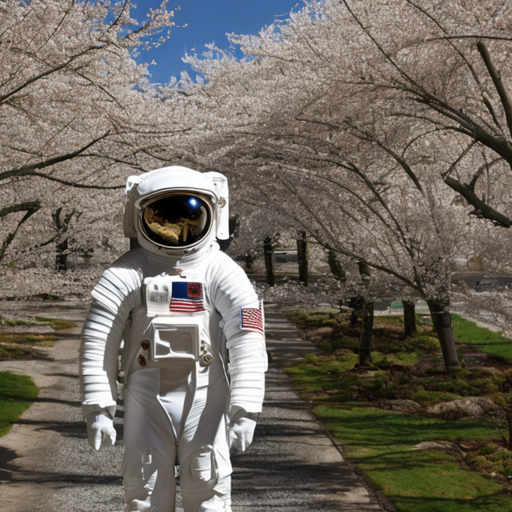

In [9]:
from PIL import Image

raw_image = Image.open(image_path_list[5]).convert("RGB")
raw_image

In [10]:
pixel_values = processor(images=[raw_image], return_tensors="pt").pixel_values.to(device)
out = model.generate(pixel_values=pixel_values, max_length=20, min_length=5)
prompts = processor.batch_decode(out, skip_special_tokens=True)
prompts

['a man in a white astronaut suit standing in front of a tree']

# 2. Load Sentence-Transformer Model for embedding

In [11]:
sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

comp_path = Path('../input/stable-diffusion-image-to-prompts/')
sample_submission = pd.read_csv(comp_path / 'sample_submission.csv', index_col='imgId_eId')

In [12]:
# load sentence transformer model
st_model = SentenceTransformer('/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2')

# 3. Define function load by batch

In [13]:
def make_batches(l, batch_size=16):
    for i in range(0, len(l), batch_size):
        yield l[i:i + batch_size]

In [14]:
images = os.listdir(comp_path/"images")
image_ids = [i.split('.')[0] for i in images]

EMBEDDING_LENGTH = 384
eIds = list(range(EMBEDDING_LENGTH))

imgId_eId = [
    '_'.join(map(str, i)) for i in zip(
        np.repeat(image_ids, EMBEDDING_LENGTH),
        np.tile(range(EMBEDDING_LENGTH), len(image_ids)))]

# 4. Make predictions

**Reference:** https://www.kaggle.com/code/ybbbat/inference-using-blip

https://www.kaggle.com/code/bibanh/blip-0-40057-baseline-blip-large-pretrained

In [15]:
BATCH_SIZE = 16

submissions = []
for batch in make_batches(images, BATCH_SIZE):
    images_batch = []
    for i, image in enumerate(batch):
        images_batch.append(Image.open(comp_path/"images"/image).convert("RGB"))

    pixel_values = processor(images=images_batch, return_tensors="pt").pixel_values.to(device)
    out = model.generate(pixel_values=pixel_values, max_length=20, min_length=5)
    prompts = processor.batch_decode(out, skip_special_tokens=True)
    
    # Calculate embeddings for submission
    embeddings = st_model.encode(prompts).flatten()
    submissions.extend(embeddings)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
submission = pd.DataFrame({"imgId_eId":imgId_eId, "val": submissions})

In [17]:
submission.to_csv("submission.csv", index=False)

In [18]:
sample_submission.head()

,val
imgId_eId,
20057f34d_0,0.018848
20057f34d_1,0.030190
20057f34d_2,0.072792
20057f34d_3,-0.000673
20057f34d_4,0.016774
